In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.manifold import TSNE
import time

device = torch.device('cpu')

# Set random seed for reproducibility
np.random.seed(1000)
torch.manual_seed(1000)

# Define the dimension
dim = 8

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors ([0, 255] -> [0.0,1.0])
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

# Get the data
for images, labels in train_loader:
    x_train = images  # [60000, 1, 28, 28]
    y_train = labels  # [60000]
    break

for images, labels in test_loader:
    x_test = images  # [10000, 1, 28, 28]
    y_test = labels  # [10000]
    break

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_test_copy = x_test.clone()  # Save a copy of x_test for later use

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Binarize the images
temp_x_train = x_train.clone()
temp_x_train[temp_x_train > 0.5] = 1
temp_x_train[temp_x_train <= 0.5] = 0

temp_x_test = x_test.clone()
temp_x_test[temp_x_test > 0.5] = 1
temp_x_test[temp_x_test <= 0.5] = 0

# Flatten the images
x_train = x_train.view(-1, 28*28)
x_test = x_test.view(-1, 28*28)

# Save labels before any modification
y_train_save = y_train.clone()
y_test_save = y_test.clone()

# Add random noise to the training data
np.random.seed(1000)
a = (np.random.rand(x_train.shape[0], x_train.shape[1]) > 0.3).astype(float)
a = torch.from_numpy(a).float()
x_train = torch.max(a, x_train)

# Convert each input into 8 dimensions
def convert_to_8dim(x, dim=8):
    x_new = torch.zeros(x.size(0), x.size(1), dim)
    a2 = (x * ((2**dim)*1 - 1e-10)).int()
    for i in range(dim):
        x_new[:, :, i] = a2 % 2
        a2 = a2 // 2
    x_new = x_new.view(-1, 28*28*dim)
    return x_new

x_train = convert_to_8dim(x_train, dim)
x_test = convert_to_8dim(x_test, dim)

print(f"x_train shape after conversion: {x_train.shape}")
print(f"x_test shape after conversion: {x_test.shape}")

# Set targets to inputs (autoencoder) AFTER conversion
y_train = x_train.clone()
y_test = x_test.clone()

print(f"y_train shape after setting targets: {y_train.shape}")
print(f"y_test shape after setting targets: {y_test.shape}")



x_train shape: torch.Size([60000, 1, 28, 28]), y_train shape: torch.Size([60000])
x_test shape: torch.Size([10000, 1, 28, 28]), y_test shape: torch.Size([10000])
x_train shape after conversion: torch.Size([60000, 6272])
x_test shape after conversion: torch.Size([10000, 6272])
y_train shape after setting targets: torch.Size([60000, 6272])
y_test shape after setting targets: torch.Size([10000, 6272])


In [21]:
# Define the autoencoder model
import torch.nn.functional as F

# Residual Block definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.activation = nn.Mish()

    def forward(self, x):
        return x + self.activation(self.conv(x))

# AutoEncoder Model definition
class AutoEncoderWithAttention(nn.Module):
    def __init__(self, input_channels=8):
        super(AutoEncoderWithAttention, self).__init__()
        self.input_channels = input_channels
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.Mish(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.Mish(),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.BatchNorm2d(128)
        )

        # Residual Block
        self.res_block = ResidualBlock(128)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=7),
            nn.BatchNorm2d(64),
            nn.Mish(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.Mish(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x, return_intermediate=False):
        x = self.encoder(x)
        x = self.res_block(x)
        if return_intermediate:
            return x
        x = self.decoder(x)
        return x

    def reconstruct_image(self, x_out):
        x_out2 = x_out.view(-1, 28, 28, self.input_channels)
        x_out3 = sum([x_out2[:, :, :, i] * (2 ** i) for i in range(self.input_channels)]) / 256
        x_out3 = x_out3.view(-1, 28 * 28)
        return x_out3

# Instantiate the model
device = torch.device('cpu')
model = AutoEncoderWithAttention(input_channels=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()

In [23]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
# Training loop (with reshaping)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Reshape inputs and targets to 4D for the convolutional layers
        inputs = inputs.view(-1, dim, 28, 28)  # Reshape to [batch_size, channels, height, width]
        targets = targets.view(-1, dim, 28, 28)  # Reshape to [batch_size, channels, height, width]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader)}")

# Extract intermediate outputs for visualization (with reshaping)
model.eval()
with torch.no_grad():
    x_test = x_test.view(-1, dim, 28, 28)  # Reshape to [batch_size, channels, height, width]
    test_mid = model(x_test.to(device), return_intermediate=True)

test_mid_np = test_mid.cpu().numpy()
print(f"Shape of intermediate outputs: {test_mid_np.shape}")



Epoch [1/10], Loss: 0.0002514817981379262
Epoch [2/10], Loss: 0.00025083374289655086
Epoch [3/10], Loss: 0.00025049286197827316
Epoch [4/10], Loss: 0.00025031391400261784
Epoch [5/10], Loss: 0.0002502195637892631
Epoch [6/10], Loss: 0.00025016920350935836
Epoch [7/10], Loss: 0.0002501422318755431
Epoch [8/10], Loss: 0.00025012756554133376
Epoch [9/10], Loss: 0.0002501194079710937
Epoch [10/10], Loss: 0.0002501147727404411
Shape of intermediate outputs: (10000, 128, 1, 1)


In [19]:
# Function to binarize images
def binarized(x_test, dim=8):
    x_test_new = torch.zeros(x_test.size(0), x_test.size(1), dim)
    a2 = (x_test * ((2**dim)*1 - 1e-10)).int()
    for i in range(dim):
        x_test_new[:, :, i] = a2 % 2
        a2 = a2 // 2
    x_test_new = x_test_new.view(-1, 28*28*dim)
    return x_test_new

# Extract intermediate outputs for visualization
def extract_intermediate_outputs(model, x_test, dim=8):
    model.eval()
    with torch.no_grad():
        x_test = x_test.view(-1, dim, 28, 28)  # Reshape to 4D [batch_size, channels, height, width]
        test_mid = model(x_test.to(device), return_intermediate=True)
    return test_mid.cpu().numpy()

# SVD whitening function
def svd_whiten(X):
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    X_white = np.dot(U, Vt)
    return X_white

# PCA for visualization
def plot_pca(test_mid_np, labels):
    pca = PCA(n_components=2)
    test_mid2 = pca.fit_transform(test_mid_np)
    for i in range(10):
        plt.scatter(test_mid2[labels == i, 0], test_mid2[labels == i, 1], s=1, label=f"Digit {i}")
    plt.legend()
    plt.show()

# t-SNE visualization
def plot_tsne(test_mid_np, labels):
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=1).fit_transform(test_mid_np)
    for i in range(10):
        plt.scatter(X_embedded[labels == i, 0], X_embedded[labels == i, 1], s=1, label=f"Digit {i}")
    plt.legend()
    plt.show()

# Fit a robust covariance estimator
def fit_robust_covariance(test_mid_np):
    robust_cov = MinCovDet().fit(test_mid_np)
    cov = robust_cov.covariance_
    mea = np.mean(test_mid_np, axis=0)
    return cov, mea

# Generate images by interpolating between two random latent vectors
def interpolate_between_latents(model, x_test, n=2, steps=100):
    np.random.seed(int(time.time()))
    indices = np.random.choice(len(x_test), n, replace=False)
    x_test_tempo = x_test[indices].clone()

    with torch.no_grad():
        test_mid = model(x_test_tempo.view(-1, 8, 28, 28).to(device), return_intermediate=True)

    test_out_big = np.zeros((28, 28 * steps))

    for i in range(steps):
        alpha = i / (steps - 1)
        interpolated_mid = (1 - alpha) * test_mid[0] + alpha * test_mid[1]

        with torch.no_grad():
            test_out = model.decoder(interpolated_mid.unsqueeze(0))

        test_out_img = model.reconstruct_image(test_out)
        test_out_img = test_out_img.cpu().numpy().reshape(28, 28)
        test_out_big[:, i * 28:(i + 1) * 28] = test_out_img

    plt.figure(figsize=(15, 2))
    plt.imshow(test_out_big, cmap='gray')
    plt.title('Interpolation between two images')
    plt.axis('off')
    plt.show()

# Generate images from random latent vectors
def generate_random_images(model, cov, mea, num_images=100):
    np.random.seed(int(time.time()))
    test_out_big = np.zeros((28, 28 * num_images))

    with torch.no_grad():
        for i in range(num_images):
            test_mid2 = np.random.multivariate_normal(mea, cov, size=1)
            test_mid = torch.from_numpy(test_mid2).float().to(device)

            with torch.no_grad():
                test_out = model.decoder(test_mid.view(1, 128, 1, 1))

            test_out_img = model.reconstruct_image(test_out)
            test_out_img = test_out_img.cpu().numpy().reshape(28, 28)
            test_out_big[:, i * 28:(i + 1) * 28] = test_out_img

    plt.figure(figsize=(15, 2))
    plt.imshow(test_out_big, cmap='gray')
    plt.title('Generated images from random latent vectors')
    plt.axis('off')
    plt.show()

Shape of intermediate outputs: (10000, 128, 1, 1)


MemoryError: Unable to allocate 5.96 TiB for an array with shape (10000, 128, 1, 10000, 128, 1) and data type float32

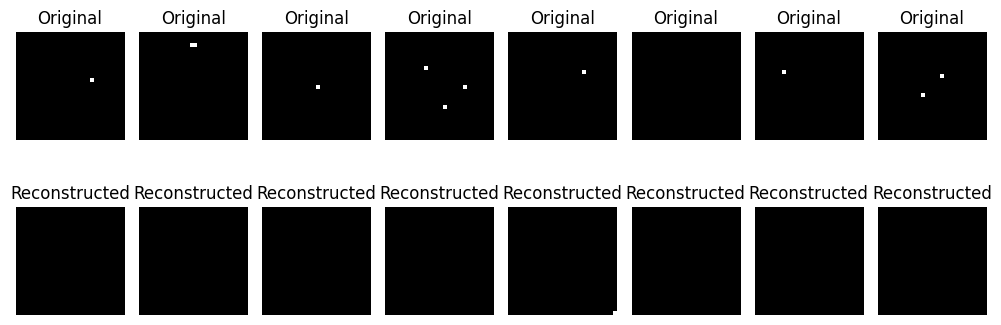

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img * 0.5 + 0.5  # Unnormalize to [0,1]
    npimg = img.cpu().numpy()
    # Select the first channel (if grayscale) or handle the display for multi-channel data
    plt.imshow(npimg[0], cmap='gray')  # Displaying the first channel
    plt.title(title)
    plt.axis('off')

dataiter = iter(test_loader)
images, _ = next(dataiter)  
images = images.to(device)

# Get reconstructed images
with torch.no_grad():
    outputs = model(images.to(device))

plt.figure(figsize=(10, 4))
for idx in range(8):
    plt.subplot(2, 8, idx+1)
    imshow(images[idx], 'Original')  # Display only the first channel

for idx in range(8):
    plt.subplot(2, 8, idx+9)
    imshow(outputs[idx], 'Reconstructed')  # Display only the first channel

plt.tight_layout()
plt.show()


In [17]:

# SVD whitening
def svd_whiten(X):
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    X_white = np.dot(U, Vt)
    return X_white

test_mid_np = svd_whiten(test_mid_np)
print(f"Whitened shape: {test_mid_np.shape}")

# PCA for visualization
pca = PCA(n_components=2)
test_mid2 = pca.fit_transform(test_mid_np)



# Plot PCA results
labels = y_test_save.numpy()
for i in range(10):
    plt.scatter(test_mid2[labels == i, 0], test_mid2[labels == i, 1], s=1, label=f"Digit {i}")
plt.legend()
plt.show()

# t-SNE visualization
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=1).fit_transform(test_mid_np)
for i in range(10):
    plt.scatter(X_embedded[labels == i, 0], X_embedded[labels == i, 1], s=1, label=f"Digit {i}")
plt.legend()
plt.show()

# Fit a robust covariance estimator
robust_cov = MinCovDet().fit(test_mid_np)
cov = robust_cov.covariance_
mea = np.mean(test_mid_np, axis=0)

# Function to binarize images
def binarized(x_test):
    x_test_new = torch.zeros(x_test.size(0), x_test.size(1), dim)
    a2 = (x_test * ((2**dim)*1 - 1e-10)).int()
    for i in range(dim):
        x_test_new[:, :, i] = a2 % 2
        a2 = a2 // 2
    x_test_new = x_test_new.view(-1, 28*28*dim)
    return x_test_new

# Generate images by interpolating between two random latent vectors
np.random.seed(int(time.time()))
n = 2
b = (np.floor(np.random.rand(n) * len(x_test))).astype(int)
x_test_tempo = x_test[b, :].clone()
with torch.no_grad():
    test_mid = model(x_test_tempo, return_intermediate=True)

test_out_big = np.zeros((28*1, 28*100))
for i in range(100):
    b2 = np.array([i / 99, 1 - i / 99])
    temp = (test_mid * torch.from_numpy(b2).float().view(n, 1)).sum(dim=0).unsqueeze(0)
    temp_neg = -temp
    temp_cat = torch.cat((temp, temp_neg), dim=1)
    with torch.no_grad():
        test_out = torch.sigmoid(model.fc_out(temp_cat))
    
    # Include binarization steps
    for repeat in range(5):
        a = (np.random.rand(test_out.shape[0], test_out.shape[1]) > 0.4).astype(float)
        a = torch.from_numpy(a).float()
        test_out = torch.max(a, test_out)
        test_out = binarized(test_out)
        with torch.no_grad():
            test_out = model(test_out)
    
    test_out_img = model.reconstruct_image(test_out)
    test_out_img = test_out_img.cpu().numpy().reshape(28, 28)
    test_out_big[0*28:(0+1)*28, i*28:(i+1)*28] = test_out_img

plt.figure(figsize=(15, 2))
plt.imshow(test_out_big, cmap='gray')
plt.title('Interpolation between two images')
plt.axis('off')
plt.show()


MemoryError: Unable to allocate 5.96 TiB for an array with shape (10000, 128, 1, 10000, 128, 1) and data type float32

In [ ]:

# Generate images from random latent vectors
np.random.seed(int(time.time()))
n = 1
with torch.no_grad():
    test_mid2 = np.random.multivariate_normal(mea + (2 * np.random.rand(100) - 1), cov, size=1)
    test_mid = torch.from_numpy(test_mid2).float()

test_out_big = np.zeros((28*1, 28*100))
for i in range(100):
    temp = test_mid
    temp_neg = -temp
    temp_cat = torch.cat((temp, temp_neg), dim=1)
    with torch.no_grad():
        test_out = torch.sigmoid(model.fc_out(temp_cat))
    
    # Include binarization steps
    for repeat in range(5):
        a = (np.random.rand(test_out.shape[0], test_out.shape[1]) > 0.4).astype(float)
        a = torch.from_numpy(a).float()
        test_out = torch.max(a, test_out)
        test_out = binarized(test_out)
        with torch.no_grad():
            test_out = model(test_out)
    
    test_out_img = model.reconstruct_image(test_out)
    test_out_img = test_out_img.cpu().numpy().reshape(28, 28)
    test_out_big[0*28:(0+1)*28, i*28:(i+1)*28] = test_out_img

plt.figure(figsize=(15, 2))
plt.imshow(test_out_big, cmap='gray')
plt.title('Generated images from random latent vectors')
plt.axis('off')
plt.show()